# Binary Classification Mohler

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob
from nltk import PorterStemmer

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling,margin_sampling,entropy_sampling

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

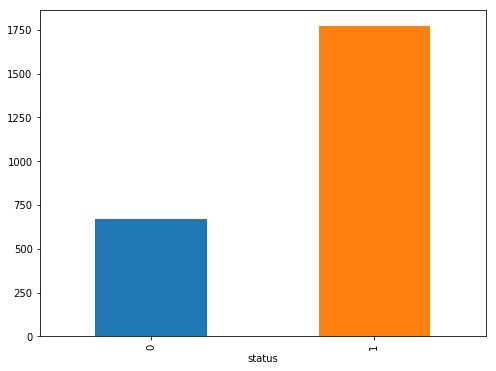

In [2]:
df = pd.read_pickle("../../dataset/final_dataset/mohler_final.pkl")

fig = plt.figure(figsize=(8,6))
df.groupby('status').student_modified.count().plot.bar(ylim=0)
plt.show()

## Supervised Learning

In [6]:
class Supervised_learner():
    def __init__(self,X,Y,model):
        self.X = X
        self.Y = Y
        self.model = model

    def learn(self):
        super_acc = []
        super_f1 = []
        for i in np.linspace(0.05, 0.8, 20):
            X_train,X_test,Y_train,Y_test = train_test_split(self.X,self.Y,test_size = 1 - i)
            model = self.model
            model.fit(X_train, Y_train)
            model_accuracy = model.score(X_test, Y_test)
            super_acc.append(model_accuracy)
            model_pred = model.predict(X_test)
            model_f1 = f1_score(Y_test,model_pred,average ="weighted")
            super_f1.append(model_f1)
        return super_acc, super_f1

## Active Learning

In [8]:
class Active_learner():
    def __init__(self,X,Y,model,data, percentage,query_method):
        self.X = X
        self.Y = Y
        self.short_df = data.copy()
        self.percent = percentage
        self.model = model
        self.query_method = query_method
        
    def learn(self):       
        # seeding
        classes = self.short_df['status'].unique()
        seed_index = []
        for i in classes:
            seed_index.append(self.short_df['status'][self.short_df['status']==i].index[0])
        seed_index

        act_data = self.short_df.copy()
        accuracy_list = []

        # initialising
        train_idx = seed_index
        X_train = self.X[train_idx]
        y_train = self.Y[train_idx]

        # generating the pool
        X_pool = np.delete(self.X, train_idx, axis=0)
        y_pool = np.delete(self.Y, train_idx)

        act_data = act_data.drop(axis=0,index = train_idx)
        act_data.reset_index(drop = True,inplace=True)


        # initializing the active learner

        learner = ActiveLearner(
            estimator = self.model,
            X_training = X_train, y_training=y_train,
            query_strategy=self.query_method
        )

        # pool-based sampling
        n_queries = int(len(X)/(100/self.percent))
        for idx in range(n_queries):
            query_idx, query_instance = learner.query(X_pool)   
            learner.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )

            # remove queried instance from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)

            act_data = act_data.drop(axis=0,index = query_idx)
            act_data.reset_index(drop=True, inplace=True)

            accuracy_list.append(learner.score(X_pool,y_pool))
#             print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
        print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data" )
        model_pred = learner.predict(X_pool)
        model_f1 = f1_score(y_pool,model_pred,average='weighted')
        return accuracy_list,model_f1

## Sultan

In [10]:

## Active learner
X = df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X = np.array(X) 
Y = df['status'].values

Percent = 80

models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100),SVC(kernel='linear' , probability=True),SVC(probability=True)]
query_methods = [uncertainty_sampling,margin_sampling,entropy_sampling]
dict_accuracy_al ={}
f1_score_list = {}
for i,model in enumerate(models):
    dict_accuracy_al[i] = []
    f1_score_list[i] = []
    print("******************************************************************************")
    for query_method in query_methods:
        ac = Active_learner(X,Y,model,df, Percent,query_method)
        accuracy_list,f1 = ac.learn()
        dict_accuracy_al[i].append(accuracy_list)
        f1_score_list[i].append(f1_score)
# dict_accuracy_al.to_pickle("../../results/dict_accuracy_al_mohler_"+str(Percent))
pkl.dump( dict_accuracy_al, open( "../../results/binary/dict_accuracy_al_mohler_"+str(Percent)+".pkl", "wb" ) )

pkl.dump( f1_score_list, open( "../../results/binary/f1_score_list_al_mohler_"+str(Percent)+".pkl", "wb" ) )

******************************************************************************
By just labelling  79.98 % of total data accuracy of  0.975  % is achieved on the unseen data


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


By just labelling  79.98 % of total data accuracy of  0.975  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.975  % is achieved on the unseen data
******************************************************************************
By just labelling  79.98 % of total data accuracy of  0.973  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.973  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.973  % is achieved on the unseen data
******************************************************************************
By just labelling  79.98 % of total data accuracy of  0.979  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.977  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.979  % is achieved on the unseen data
******************************************************************************
By just lab

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


By just labelling  79.98 % of total data accuracy of  0.971  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.971  % is achieved on the unseen data
******************************************************************************
By just labelling  79.98 % of total data accuracy of  0.971  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.971  % is achieved on the unseen data
By just labelling  79.98 % of total data accuracy of  0.973  % is achieved on the unseen data


In [11]:
# supervised learning
X = df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X = np.array(X) 
Y = df['status'].values
iteration_count = 2

## Supervised learner
models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100), \
          SVC(kernel='linear' , probability=True),SVC(probability=True)]


dict_accuracy_sl_min = {}
dict_accuracy_sl_avg = {}
dict_accuracy_sl_max = {}
dict_f1_score_sl = {}

for i, model in enumerate(models):
    new_accuracy_list = []
    f1_list = []
    for _ in range(iteration_count):
        sl = Supervised_learner(X,Y,model)
        accuracy,f1score = sl.learn()
        new_accuracy_list.append(accuracy)
        f1_list.append(f1score)
    dict_accuracy_sl_min[i]= np.min(new_accuracy_list,axis = 0)
    dict_accuracy_sl_avg[i]= np.mean(new_accuracy_list,axis = 0)
    dict_accuracy_sl_max[i]= np.max(new_accuracy_list,axis = 0)
    dict_f1_score_sl[i]= np.mean(f1_list,axis=0) 


pkl.dump( dict_accuracy_sl_min, open( "../../results/binary/dict_accuracy_min_mohler.pkl", "wb" ) )
pkl.dump( dict_accuracy_sl_max, open( "../../results/binary/dict_accuracy_max_mohler.pkl", "wb" ) )
pkl.dump( dict_accuracy_sl_avg, open( "../../results/binary/dict_accuracy_avg_mohler.pkl", "wb" ) )

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


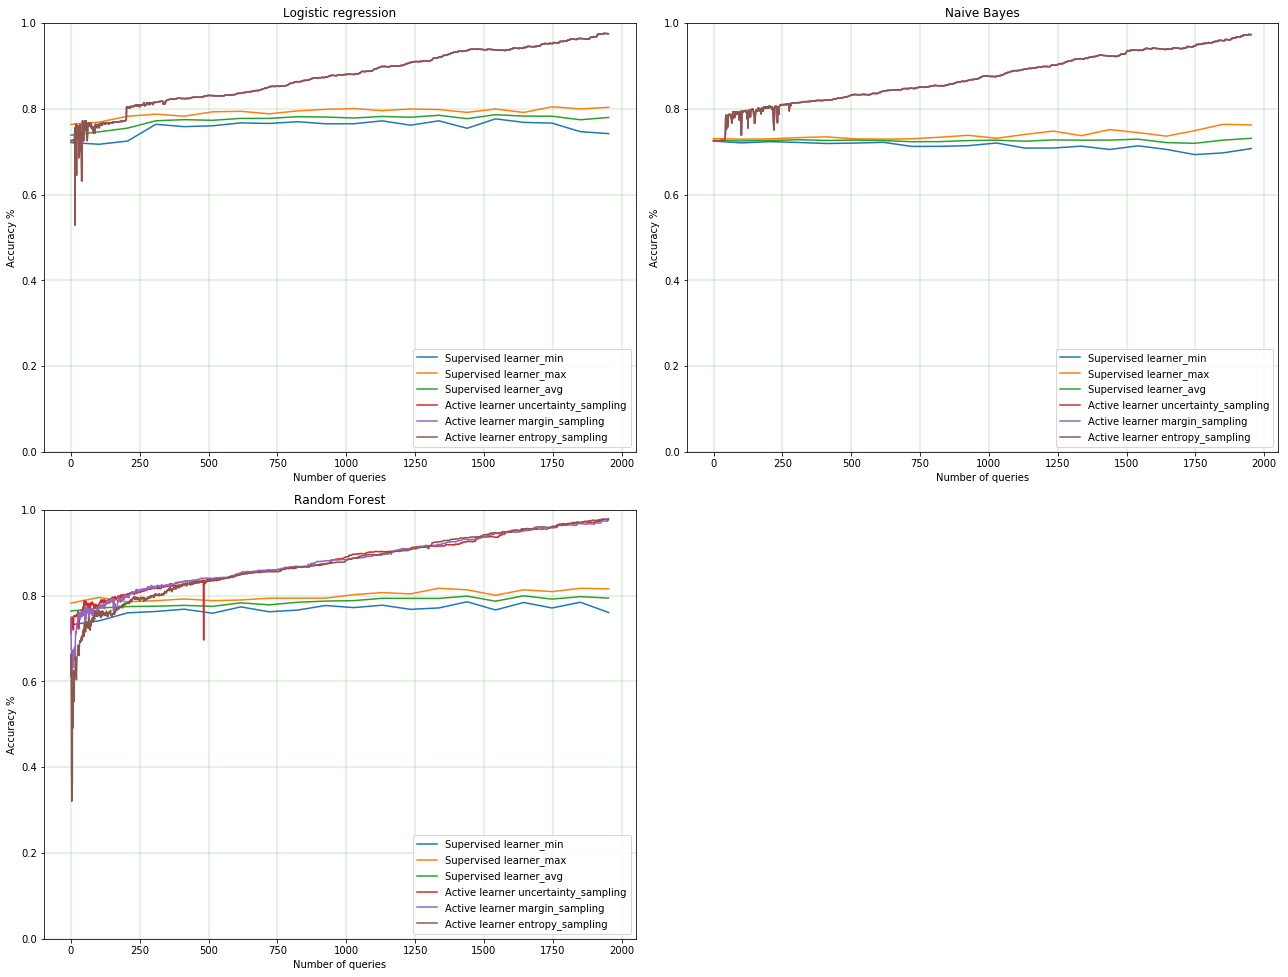

In [2]:
#plotting
dict_accuracy_al = pkl.load( open("../../results/binary/dict_accuracy_al_mohler_"+str(80)+".pkl","rb"))
dict_accuracy_sl_min = pkl.load( open("../../results/binary/dict_accuracy_min_mohler.pkl","rb"))
dict_accuracy_sl_max = pkl.load( open("../../results/binary/dict_accuracy_max_mohler.pkl","rb"))
dict_accuracy_sl_avg = pkl.load( open("../../results/binary/dict_accuracy_avg_mohler.pkl","rb"))

## plotting
fig = plt.figure(figsize=(18,20))
model_title = ["Logistic regression","Naive Bayes","Random Forest","SVC-linear","SVC"]
query_strategy = ["uncertainty_sampling","margin_sampling","entropy_sampling"]
for i in range(0,3):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_min[i],label = "Supervised learner_min")
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_max[i],label = "Supervised learner_max")
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_avg[i],label = "Supervised learner_avg")
    for j in range(len(query_strategy)):
        ax.plot(dict_accuracy_al[i][j],label = "Active learner {}".format(query_strategy[j]))
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of queries")
    ax.set_ylabel("Accuracy %")
    ax.set_title(model_title[i])
    ax.grid(color='g', linestyle='-', linewidth=0.2)
    ax.set_ylim(0,1)
#     ax.set_xticks([i/25 for i in np.linspace(0,2000,5)])
plt.tight_layout()

plt.show()

## Bag of Words

In [ ]:
#creating inputs and labels for BOW
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = df['statusbinary/'].values

Percent = 80

# models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100),SVC(kernel='linear' , probability=True),SVC(probability=True)]
models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100)]
query_methods = [uncertainty_sampling,margin_sampling,entropy_sampling]
dict_accuracy_al ={}
f1_score_list = {}
for i,model in enumerate(models):
    dict_accuracy_al[i] = []
    f1_score_list[i] = []
    print("******************************************************************************")
    for query_method in query_methods:
        ac = Active_learner(X,Y,model,df, Percent,query_method)
        accuracy_list,f1 = ac.learn()
        dict_accuracy_al[i].append(accuracy_list)
        f1_score_list[i].append(f1_score)
# dict_accuracy_al.to_pickle("../../results/dict_accuracy_al_mohler_"+str(Percent))
pkl.dump( dict_accuracy_al, open( "../../results/binary/dict_accuracy_al_mohler_bag_"+str(Percent)+".pkl", "wb" ) )

pkl.dump( f1_score_list, open( "../../results/binary/f1_score_list_al_mohler_bag_"+str(Percent)+".pkl", "wb" ) )


In [ ]:
# supervised learning

iteration_count = 2

## Supervised learner
# models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100), \
#           SVC(kernel='linear' , probability=True),SVC(probability=True)]
models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100)]
dict_accuracy_sl_min = {}
dict_accuracy_sl_avg = {}
dict_accuracy_sl_max = {}
dict_f1_score_sl = {}

for i, model in enumerate(models):
    new_accuracy_list = []
    f1_list = []
    for _ in range(iteration_count):
        sl = Supervised_learner(X,Y,model)
        accuracy,f1score = sl.learn()
        new_accuracy_list.append(accuracy)
        f1_list.append(f1score)
    dict_accuracy_sl_min[i]= np.min(new_accuracy_list,axis = 0)
    dict_accuracy_sl_avg[i]= np.mean(new_accuracy_list,axis = 0)
    dict_accuracy_sl_max[i]= np.max(new_accuracy_list,axis = 0)
    dict_f1_score_sl[i]= np.mean(f1_list,axis=0) 


pkl.dump( dict_accuracy_sl_min, open( "../../results/binary/dict_accuracy_min_mohler_bag.pkl", "wb" ) )
pkl.dump( dict_accuracy_sl_max, open( "../../results/binary/dict_accuracy_max_mohler_bag.pkl", "wb" ) )
pkl.dump( dict_accuracy_sl_avg, open( "../../results/binary/dict_accuracy_avg_mohler_bag.pkl", "wb" ) )    

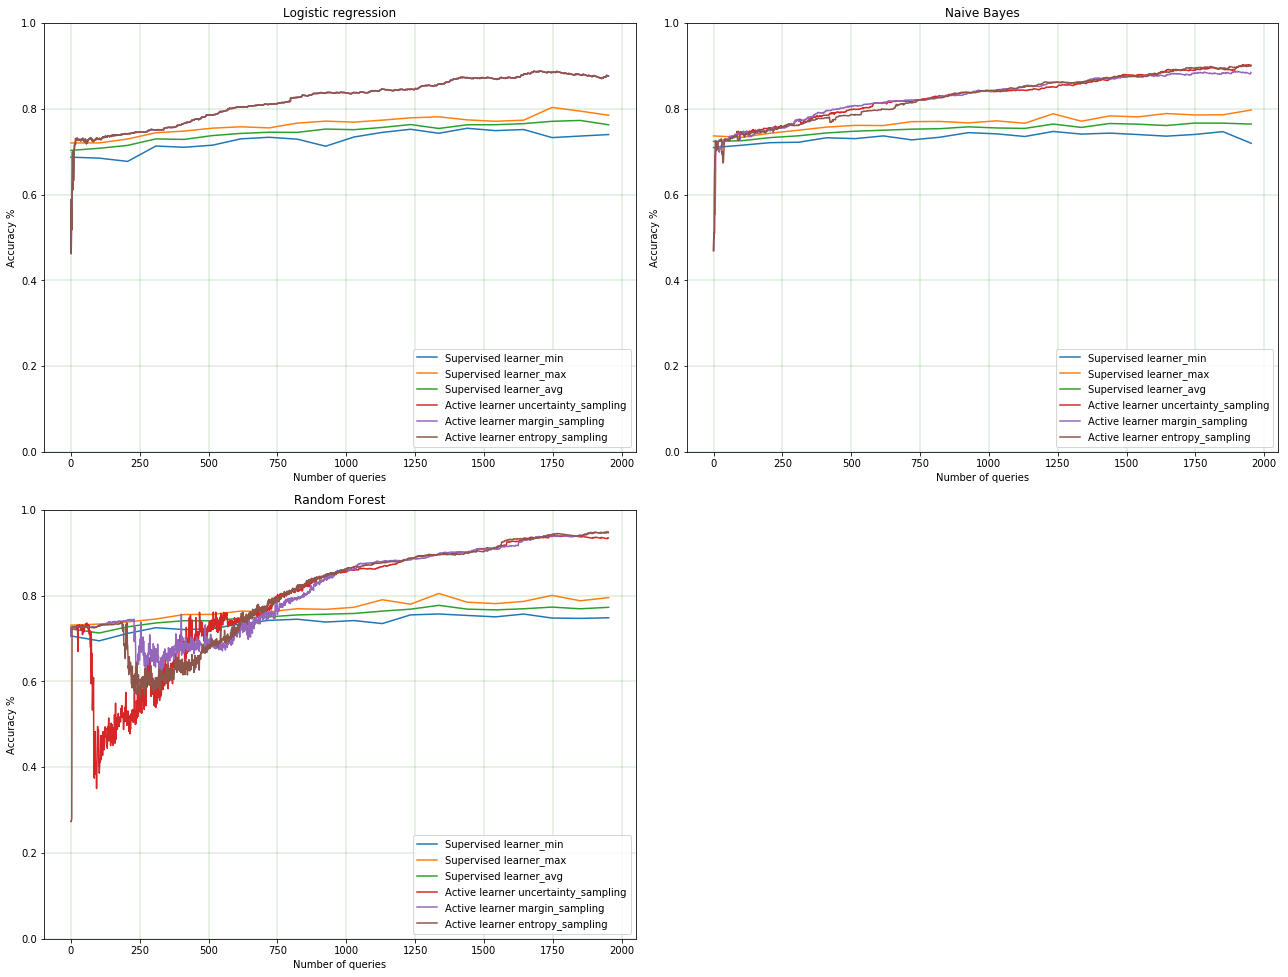

In [3]:
#plotting
dict_accuracy_al = pkl.load( open("../../results/binary/dict_accuracy_al_mohler_bag_"+str(80)+".pkl","rb"))
dict_accuracy_sl_min = pkl.load( open("../../results/binary/dict_accuracy_min_mohler_bag.pkl","rb"))
dict_accuracy_sl_max = pkl.load( open("../../results/binary/dict_accuracy_max_mohler_bag.pkl","rb"))
dict_accuracy_sl_avg = pkl.load( open("../../results/binary/dict_accuracy_avg_mohler_bag.pkl","rb"))

## plotting
fig = plt.figure(figsize=(18,20))
model_title = ["Logistic regression","Naive Bayes","Random Forest","SVC-linear","SVC"]
query_strategy = ["uncertainty_sampling","margin_sampling","entropy_sampling"]
for i in range(0,3):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_min[i],label = "Supervised learner_min")
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_max[i],label = "Supervised learner_max")
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_avg[i],label = "Supervised learner_avg")
    for j in range(len(query_strategy)):
        ax.plot(dict_accuracy_al[i][j],label = "Active learner {}".format(query_strategy[j]))
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of queries")
    ax.set_ylabel("Accuracy %")
    ax.set_title(model_title[i])
    ax.grid(color='g', linestyle='-', linewidth=0.2)
    ax.set_ylim(0,1)
    
plt.tight_layout()

plt.show()

## Tf-IDf

In [5]:
#creating inputs and labels for TFidf
Tf = TfidfVectorizer()
student_answer_count_vector = Tf.fit_transform(df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = df['status'].values

Percent = 80

# models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100),SVC(kernel='linear' , probability=True),SVC(probability=True)]
models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100)]
query_methods = [uncertainty_sampling,margin_sampling,entropy_sampling]
dict_accuracy_al ={}
f1_score_list = {}
for i,model in enumerate(models):
    dict_accuracy_al[i] = []
    f1_score_list[i] = []
    print("******************************************************************************")
    for query_method in query_methods:
        ac = Active_learner(X,Y,model,df, Percent,query_method)
        accuracy_list,f1 = ac.learn()
        dict_accuracy_al[i].append(accuracy_list)
        f1_score_list[i].append(f1_score)
        
        
# dict_accuracy_al.to_pickle("../../results/dict_accuracy_al_mohler_"+str(Percent))
pkl.dump( dict_accuracy_al, open( "../../results/binary/dict_accuracy_al_mohler_tfidf_"+str(Percent)+".pkl", "wb" ) )

pkl.dump( f1_score_list, open( "../../results/binary/f1_score_list_al_mohler_tfidf_"+str(Percent)+".pkl", "wb" ) )


In [6]:
# supervised learning

iteration_count = 2

## Supervised learner
# models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100), \
#           SVC(kernel='linear' , probability=True),SVC(probability=True)]
models = [LogisticRegression(),MultinomialNB(),RandomForestClassifier(n_estimators=100)]
dict_accuracy_sl_min = {}
dict_accuracy_sl_avg = {}
dict_accuracy_sl_max = {}
dict_f1_score_sl = {}

for i, model in enumerate(models):
    new_accuracy_list = []
    f1_list = []
    for _ in range(iteration_count):
        sl = Supervised_learner(X,Y,model)
        accuracy,f1score = sl.learn()
        new_accuracy_list.append(accuracy)
        f1_list.append(f1score)
    dict_accuracy_sl_min[i]= np.min(new_accuracy_list,axis = 0)
    dict_accuracy_sl_avg[i]= np.mean(new_accuracy_list,axis = 0)
    dict_accuracy_sl_max[i]= np.max(new_accuracy_list,axis = 0)
    dict_f1_score_sl[i]= np.mean(f1_list,axis=0) 
    

pkl.dump( dict_accuracy_sl_min, open( "../../results/binary/dict_accuracy_min_mohler_tfidf.pkl", "wb" ) )
pkl.dump( dict_accuracy_sl_max, open( "../../results/binary/dict_accuracy_max_mohler_tfidf.pkl", "wb" ) )
pkl.dump( dict_accuracy_sl_avg, open( "../../results/binary/dict_accuracy_avg_mohler_tfidf.pkl", "wb" ) )

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

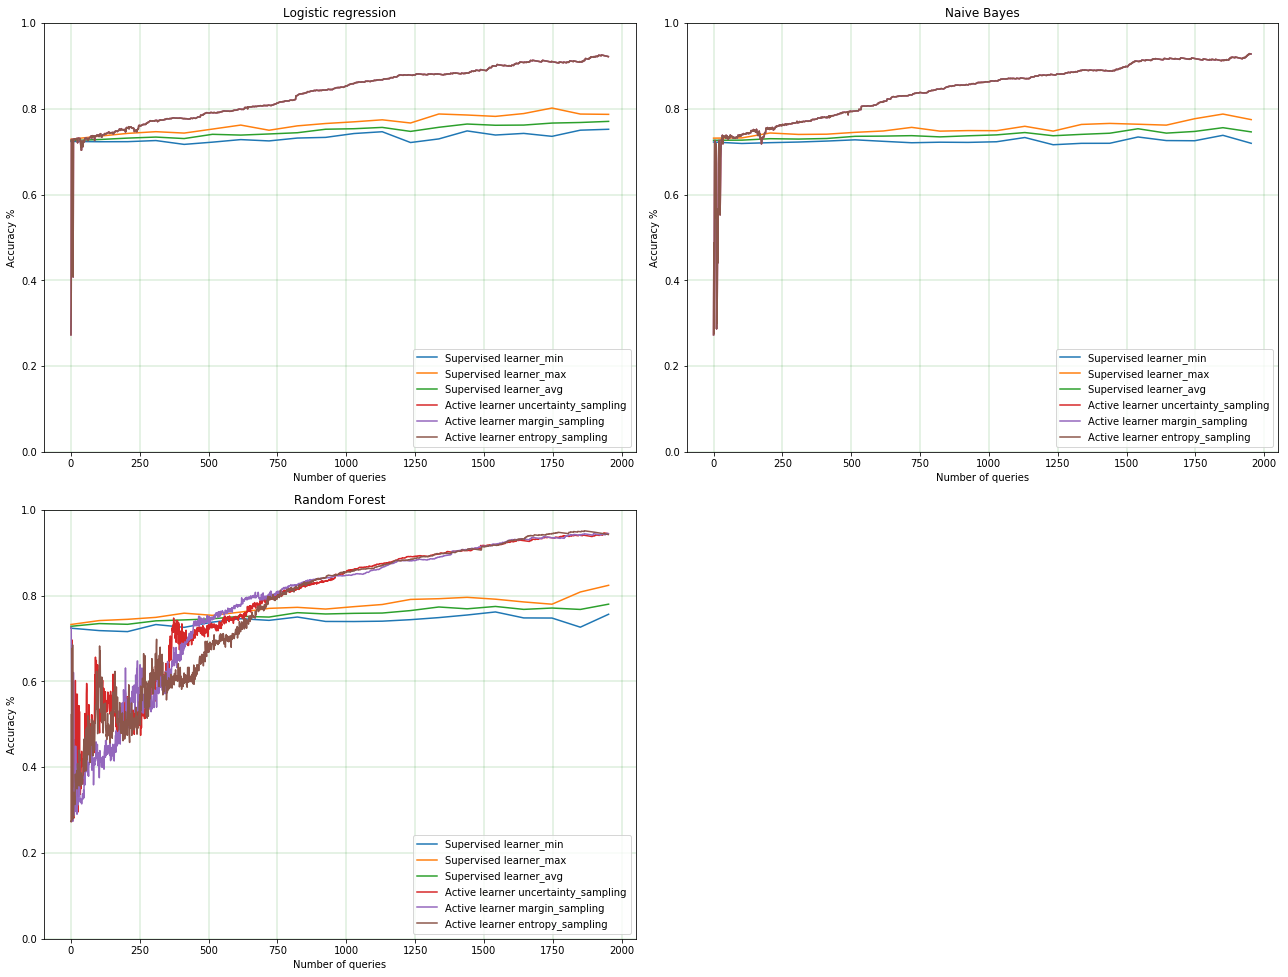

In [4]:
#plotting
dict_accuracy_al = pkl.load( open("../../results/binary/dict_accuracy_al_mohler_tfidf_"+str(80)+".pkl","rb"))
dict_accuracy_sl_min = pkl.load( open("../../results/binary/dict_accuracy_min_mohler_tfidf.pkl","rb"))
dict_accuracy_sl_max = pkl.load( open("../../results/binary/dict_accuracy_max_mohler_tfidf.pkl","rb"))
dict_accuracy_sl_avg = pkl.load( open("../../results/binary/dict_accuracy_avg_mohler_tfidf.pkl","rb"))

## plotting
fig = plt.figure(figsize=(18,20))
model_title = ["Logistic regression","Naive Bayes","Random Forest","SVC-linear","SVC"]
query_strategy = ["uncertainty_sampling","margin_sampling","entropy_sampling"]
for i in range(0,3):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_min[i],label = "Supervised learner_min")
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_max[i],label = "Supervised learner_max")
    ax.plot(np.linspace(0, len(dict_accuracy_al[1][2]), 20), dict_accuracy_sl_avg[i],label = "Supervised learner_avg")
    for j in range(len(query_strategy)):
        ax.plot(dict_accuracy_al[i][j],label = "Active learner {}".format(query_strategy[j]))
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of queries")
    ax.set_ylabel("Accuracy %")
    ax.set_title(model_title[i])
    ax.grid(color='g', linestyle='-', linewidth=0.2)
    ax.set_ylim(0,1)
    
plt.tight_layout()

plt.show()